1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

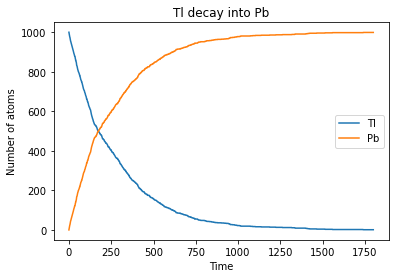

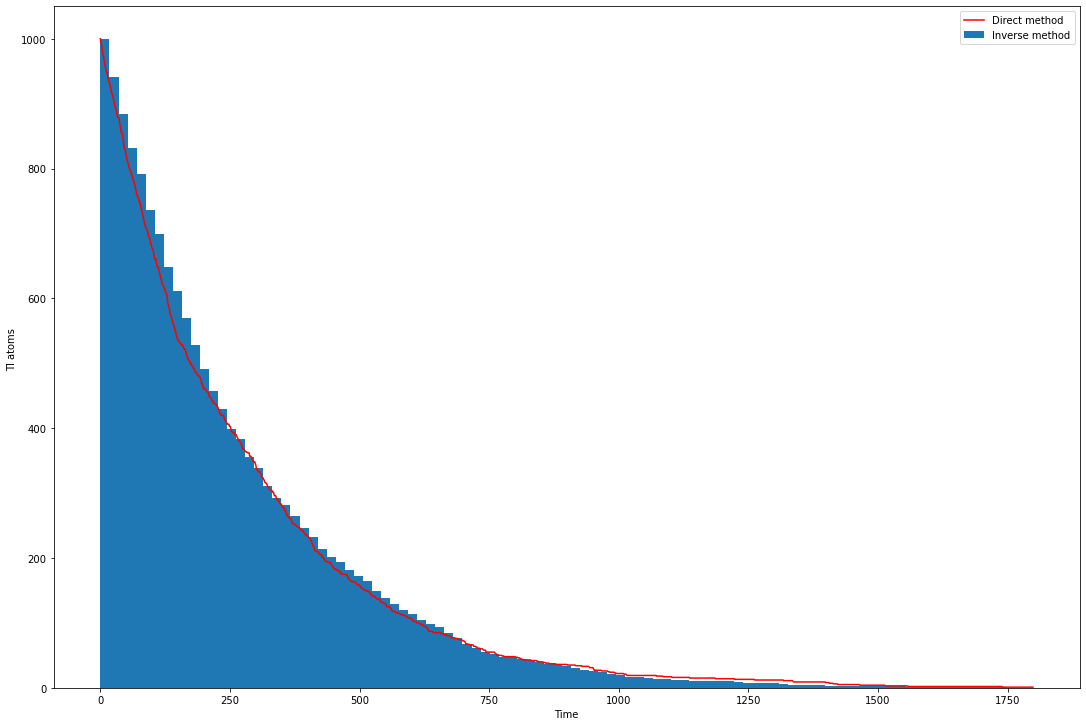

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
np.random.seed(1995)

#1)

N=1000
tau=3.052*60

N_Tl = [N]
N_Pb = [0]
test = np.random.uniform(0,1,1000)
Tl = N
Pb = 0

def p(t): #probability of decay
    tau=3.052*60 
    return 1 - 2**(-(t)/tau)

for t in range(1,1800):  
    for i in range(0,len(test)):     
        if i >= len(test):       
            break
        else:
            if ((test[i] < p(t)) and (N_Tl[-1] > 0)):
                test=np.delete(test,[i])
                Pb += 1
                Tl -= 1
                
    N_Tl.append(Tl)
    N_Pb.append(Pb)
    
plt.plot(N_Tl, label="Tl")
plt.plot(N_Pb, label="Pb")
plt.xlabel("Time")
plt.ylabel("Number of atoms")
plt.title("Tl decay into Pb")
plt.legend()

#2)

def inverse_p(u):
    return -np.log(1 - u)*tau/(np.log(2))

u = np.random.uniform(0,1,1000)
pi = inverse_p(u)
fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.hist(pi, cumulative=-1, bins=100, label="Inverse method")
#cumulative -1 computes cumulative distribution reversing it(so that p > 0 = 1)

ax.plot(np.arange(0,1800),N_Tl, color='red', label="Direct method")
fig.tight_layout()
ax.set_ylabel("Tl atoms ")
ax.set_xlabel("Time")
ax.legend(loc="best")

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

Percentage of bounce back beam 0.001495


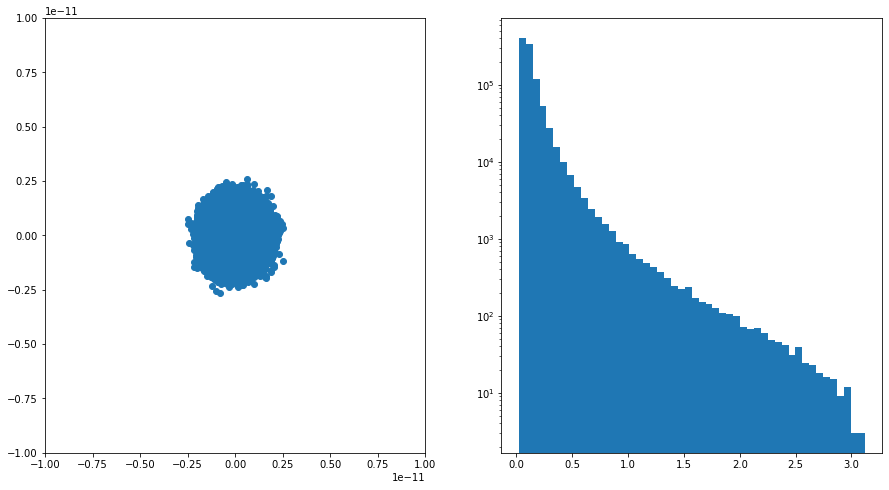

In [2]:
N = 10**6
Z = 79
e_minus=1.602176565*10**(-19)
E=7.7*10**(6)*e_minus
alpha=5.2917721067*10**(-11)
e0=8.8541878176*10**(-12)

beam_x = np.random.normal(0, alpha/100, N) 
beam_y = np.random.normal(0, alpha/100, N)

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(15,8))
ax0.scatter(beam_x, beam_y)
ax0.set_ylim(-10**(-11),10**(-11))
ax0.set_xlim(-10**(-11),10**(-11))

b=np.sqrt((beam_x)**2+(beam_y)**2)

theta = 2*np.arctan((Z*e_minus*e_minus)/(2*np.pi*e0*E*b))

ax1.hist(theta,bins=50)
ax1.set_yscale("log")

bounce_percentage = len(theta[theta > np.pi/2])/len(theta)
print("Percentage of bounce back beam", (bounce_percentage))

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

Area via Hir or Miss: 1.44646 with error 0.0028296174094742913
Area via mean value: 1.4510358023793877 with error 0.005280489906367032


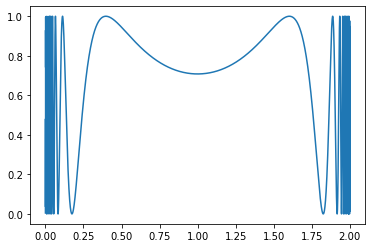

In [3]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x = np.linspace(0.000001,1.99999,10000)
plt.plot(x,f(x))

N=100000
area = 2
rand_x = np.random.uniform(0,2,N)
rand_y = np.random.uniform(0,1,N)
hit = 0
for i in range(N):
    if (rand_y[i] < f(rand_x[i])):
        hit +=1

area_hit = area*hit/N         
err = area*np.sqrt((hit/N)*(1-hit/N)/N)
print("Area via Hir or Miss:", area_hit, "with error", err)

#mean value method
area_mean_value = area*np.sum(f(x))/len(x)
err1 = area*np.std(f(x))/np.sqrt(len(x))
print("Area via mean value:", area_mean_value, "with error", err1)

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [4]:
N=10**5

def sphere(point,radius=1):
    if np.sum(point**2) <= radius*radius:
        return 1
    else:
        return 0
x = -1
y = 1
#now we have to create a dataset
pnts = pd.DataFrame({"x1":np.random.uniform(x,y,N), "x2":np.random.uniform(x,y,N)})

hit=pnts.apply(sphere,axis=1).sum()/N
integral = (y-x)**2*hit
err = (y-x)**2*np.sqrt((hit)*(1-hit)/N)

print("2d integral: ", integral, "error:",err)

2d integral:  3.13888 error: 0.005198992542406654


In [5]:
N_dim = 10

ND_points = pd.DataFrame()
for i in range(N_dim):
        name="x"+str(i)
        ND_points[name]=np.random.uniform(x,y,N)
        
ND_points.head()
hit_frac_ND=(ND_points.apply(sphere,axis=1).sum())/N
integral_ND = ((y-x)**N_dim)*hit_frac_ND
err_ND = ((y-x)**N_dim)*np.sqrt((hit_frac_ND)*(1-hit_frac_ND)/N)


print("10D integral:", integral_ND, "error", err_ND)

print("Actual value:", math.pi**(N_dim/2)/math.gamma(N_dim/2 + 1))

10D integral: 2.46784 error 0.15877587744158114
Actual value: 2.550164039877345


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [6]:
x = np.linspace(0.000001,1,10**4)

def f(x):
    return x**(-1/2)/(np.exp(x)+1)
def g(x):
    return x**(-1/2)

x_temp = pd.DataFrame(x)
int_g = float(x_temp.apply(g).mean())    #integral of the importance sampling function between 0 and 1 (via mean value)

def importance_sampling(x, int_g):
    return(np.mean(f(x)/g(x))*int_g)

integral = importance_sampling(x, int_g)
print("Integral importance sampling:", integral)

Integral importance sampling: 0.7921071944276734
